# Interaction with the ElectricGridEnv

This is the second notebook belonging to the environment (`env`). In the previous one we saw how to set up a simple `env` and showed some of the basic parameters (see `Env_Create_DEMO.ipynb`). This notebook is intended to show how to interact with the env and, above all, how to extract, store the data and covers the following topics:


- ### Apply actions,
- ### Data hook (how to tap the simulated data stream),
- ### AC grid example.

## Basic interaction with the environment

The dynamic behaviour of the environment is simulated using linear state-space models. It interacts step-wise with the agent/controller like shown in the figure below. Based on the input/action `u` at timestep `k` the state `x` is calculated.

![](figures/RL_interaction.png)

Based on that action `u_k` and the internal state-space model, the system response is evolved for one timestep and the new states `x_k+1` are calulated.
The state-space model is defined depending on the electric components - for more information about the ordinary differential equations behind,... see NodeConstructor_DEMO.ipynb

In this example notebook we will use the described parameter dict to define a simple, small example `env` to learn how to interact with it.
This environment consists of a single phase electrical power grid with 1 source and 1 load as shown in the figure below. For reasons of clarity, only phase a is shown:

![](figures/S1_L1_all.png)

To get an `env` consisting of that specific setting with the correct filter type and load, the parameter dict is defined in beforehand and handed over to the `env`.

Instead of `num_sorces` and `num_loads`, now the parameter dict and the connection matrix `CM` is used which defines if there is a connection between two nodes (e.g., source <-> load) or not. 
If there is a connetion the corresponding matrix entry is not zero, if there is no connection the entry is `0`. For more information about the CM matrix see `NodeConstructor_Application_DEMO.ipynb`.

To create a usefull example we first calulate a load which fits in case of power rating to the power of the source.
Therefore, the function `ParallelLoadImpedance()` provied by the `ElectricGrid` package is used which calulates the passive parameters for a load for specified apparant power.

In [14]:
using ElectricGrid

In [15]:
S_source = 200e3

S_load = 150e3
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = ParallelLoadImpedance(S_load, pf_load, v_rms)

(1.058, Inf, Inf, 1.058 + 0.0im)

Then we use these values during definition of the `env` in the parameter dict.

In [16]:
CM = [0. 1.
    -1. 0.]

parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Step", "fltr" => "LC"),
                        ],
        "load"   => Any[
                        Dict{Any, Any}("impedance" => "R", "R" => R_load),
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4, "i_limit" => 1e4, "v_limit" => 1e4,),
                        ],
        "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.0)
    )


env = ElectricGridEnv(CM = CM, parameters = parameters)

env.state_ids[1:5]

5-element Vector{String}:
 "source1_i_L1_a"
 "source1_v_C_filt_a"
 "source1_v_C_cables_a"
 "cable1_i_L_a"
 "load1_v_C_total_a"

As can be seen, the five states marked in the equivalent circuit diagram in the figure above can be found via the `env.state_ids`.
Analog, the `action_ids` can be found which consists of 3 entries, one per phase for the defined source.


In [17]:
env.action_ids

3-element Vector{String}:
 "source1_u_a"
 "source1_u_b"
 "source1_u_c"

To interact with the env, the function `env(action)` can be called:

In [18]:
env([0.2, 0.2, 0.2])

15-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Here, the source gets an action of `0.2` to all three phases.
As can be seen, the states have changed from 0 to different values.

This interaction can be done in a loop while the state is logged during this process:

In [19]:
# run 3 steps
reset!(env)
for _ in 1:3
    env([0.2, 0.2, 0.2])
end

env.state[1:5]  # print states after 3 steps

5-element Vector{Float64}:
 0.06548135420290145
 0.013847803005637331
 0.01692657505439206
 0.0012287741401077802
 0.020386045162012048

The `control_type` of the source is chosen as classic in `mode => Step`. That means it is open loop and a step is given to the input resulting in an input voltage of `env.nc.parameters["grid"]["v_rms"]`. For more information about possible control modes, see `ClassicalController_Notebook` or documentation.

## The MultiController

The `ElectricGrid` toolbox provides a more enhanced method to run an experiment with a specific number of steps and even more episodes.
It is based in the `run` command provided by the [ReinforcementLeaning.jl/run](https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/blob/master/src/ReinforcementLearningCore/src/core/run.jl) toolbox and, therefore, can be used to `learn` a control task or to `simulate` a fixed setup.

First we take a look onto simulating the behaviour of an env without learning. Therefore, the `Simulate()` function from the `MultiController` is used. 
This acts as a configuration tool to define the corresponding classic controllers and RL agents.
Additionally, it links inputs to the `env.state_ids` and outputs to the `env.action_ids`.

In our example, we only apply classic controllers to learn how the tool works (learning with RL agents is investigated in `RL_Single_Agent_DEMO.ipynb`). 
The interaction of the different components (env, agent, classic controllers, ...) is shown in the diagram below.



![](figures/Overview_EG.png "")


The depicted multiagent ensures that the states and actions for every source are exchanged with the correct agent or classic controller. This is depending on the `control_types` and `mode`s.
Therefore, the `SetupAgents(env)` method returns a `Controller` of type `MultiController`.

In [20]:
Controller = SetupAgents(env);

Then, the experiment is executed for (default) one episode. The length of the episode is defined depending on the parameter `env.maxsteps` (default = 500), which alternatively can be defined via `env.t_end` and `env.ts`. 
Inside `Simulate()` the run command (RL.base) executes 500 steps applying the defined controllers in the env.
Every step the control inputs are calulated based on the corresponding states and the env is evolved for `ts`. Then, the new state is given to the controller/agent again. 

The 500 steps only gets executed if none of the defined voltage and current limits of the states are exceeded (which would be equivalent to a system crash).
In that case, a flag in the env is set (`env.done = true`) which terminates the episode.

To investigate the env <-> agent interaction (without learning), we now execute the `Simulate()` method for one episode.

In [21]:
hook = Simulate(Controller, env);
hook.df

,episode,time,source1_v_d,source1_v_q,source1_i_d,source1_i_q,source1_p_inv
,Int64,Float32,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0001,0.0,0.0,0.0,0.0,0.0
3,1,0.0002,0.0,0.0,0.0,0.0,0.0
4,1,0.0003,0.0,0.0,0.0,0.0,0.0
5,1,0.0004,0.0,0.0,0.0,0.0,0.0
6,1,0.0005,0.0,0.0,0.0,0.0,0.0
7,1,0.0006,0.0,0.0,0.0,0.0,0.0
8,1,0.0007,0.0,0.0,0.0,0.0,0.0
9,1,0.0008,0.0,0.0,0.0,0.0,0.0


If not defined in beforehand and handed over to the `Simulate()` methode, it returns a default `hook`. 



## Data-Hook (how to tap the simulated data stream)

To collect the data - so how the states evolved over time by the chosen actions - hooks ([ReinforcmentLearning.jl/data-hooks](https://juliareinforcementlearning.org/docs/How_to_use_hooks/)) are used which will be executed at different stages of the experiment.
Via theses hooks the data to be collected is stored in a `DataFrame` labeled via the state and action IDs. This all happens using the `DataHook` provided by the `ElectricGrid` package.

This `DataFrame` can be seen in the output of the upper cell. It contains 500 rows - one for each simulated step.
In the different colons the information about the simulation is stored, e.g., the number of the episode, time, states, actions...
By default a `DefaultDataHook` is generated which collects all available information about the states of the `env`. 

If we are interested how the state of the current through the filter inductor of source 1 (first state in the env `source1_i_L1_a`) evolves over time, we can grap the data like follows:

In [22]:
id = env.state_ids[1] # get first state_id
println(id)
hook.df[:, id]

source1_i_L1_a


500-element Vector{Float64}:
   0.0
   0.0
  64.38793241613949
 118.5118638524073
 159.6623242035541
 188.4161060129909
 206.7479466095761
 216.9637166049256
 221.29328943565338
 221.71322649159114
   ⋮
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519

If we only want to log specific states during the experiment, a `DataHook` can be defined in beforehand.
It only has to be defined which states and actions should be logged during initialisation. Then the `hook` has to be handed over to the `Simulate()` (or `Learn()`) command.

In the following, we will collect only the state `"source1_i_L1_a"` and the first action `"source1_u_a"`.
Alternatively, for example the number of source can be used to collect all the data for a specific source (compare out-commented example code). A lot of other flags can be defined to collect more measurements (RMS, reward, powers,...).
For more details we refer to the documentation and the other example notebooks.

In [23]:
hook = DataHook(collect_state_ids = ["source1_i_L1_a"],
                collect_action_ids = ["source1_u_a"]
                #collect_sources  = [1]  # alternative collect all data of source 1 
                );

Simulate(Controller, env, hook=hook);

hook.df

,episode,time,source1_i_L1_a,source1_v_L1_a,action,next_state_source1_i_L1_a
,Int64,Float32,Float64,Float64,Array…,Float64
1,1,0.0,0.0,0.0,"[0.575, 0.575, 0.575]",0.0
2,1,0.0001,0.0,0.0,"[0.575, 0.575, 0.575]",64.3879
3,1,0.0002,64.3879,205.206,"[0.575, 0.575, 0.575]",118.512
4,1,0.0003,118.512,163.059,"[0.575, 0.575, 0.575]",159.662
5,1,0.0004,159.662,118.471,"[0.575, 0.575, 0.575]",188.416
6,1,0.0005,188.416,79.1171,"[0.575, 0.575, 0.575]",206.748
7,1,0.0006,206.748,47.433,"[0.575, 0.575, 0.575]",216.964
8,1,0.0007,216.964,23.6258,"[0.575, 0.575, 0.575]",221.293
9,1,0.0008,221.293,7.07961,"[0.575, 0.575, 0.575]",221.713


Investigating the `DataFrame` we can see, that even more states then planned are logged.
The `ElectricGrid` framework stores all information available with regards to the state we have chosen.
Here, additionally the voltage across the inductor and the state after the action is applied is stored as well. 
For more detailed information, see `API-Doku -> DataHook`.

After the experiment, the `RenderHookResults()` function provided by the `ElectricGrid` package can be used to show the results of the simulated episode.
States and actions which are logged with the `DataHook` can be selected to be plotted:

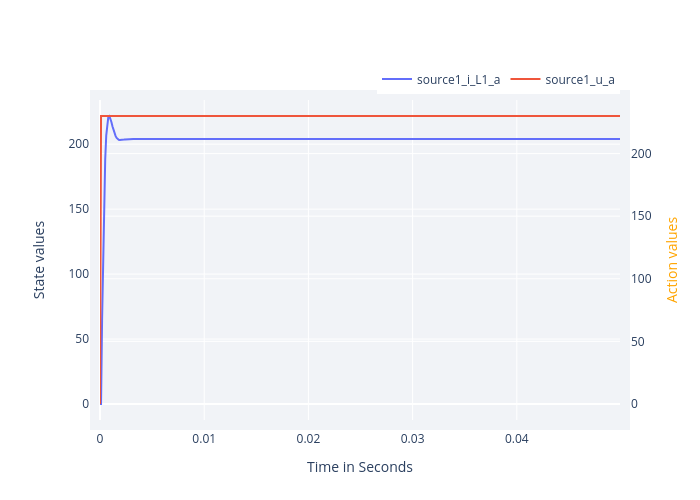

In [24]:
RenderHookResults(hook = hook, 
                    episode = 1,
                    states_to_plot  = ["source1_i_L1_a"],  
                    actions_to_plot = ["source1_u_a"])

As can be seen, the state `"source1_i_L1_a"` (belonging to the left y-axis) and the action `"source1_u_a"` (right y-axis) are plotted over the 500 timesteps while one timestep takes `ts = 1e-4` s resulting in an episode time of 0.05 s.
Here, the states and actions plotted/collected are not normalised.

Above the `control_type` of the source is chosen as classic in `mode => Step`. 
The implements an open-loop circuit.
As action a step is given to the inputs resulting in an input voltage of `env.nc.parameters["grid"]["v_rms"]`. 
For more information about possible control modes, see `ClassicalController_Notebook` or documentation.

## AC grid example
To run an AC grid where the source creates a sinusoidal voltage with the frequency of `env.nc.parameters["grid"]["f_grid"]` just the control mode has to be changed from `Step` to `Swing`.

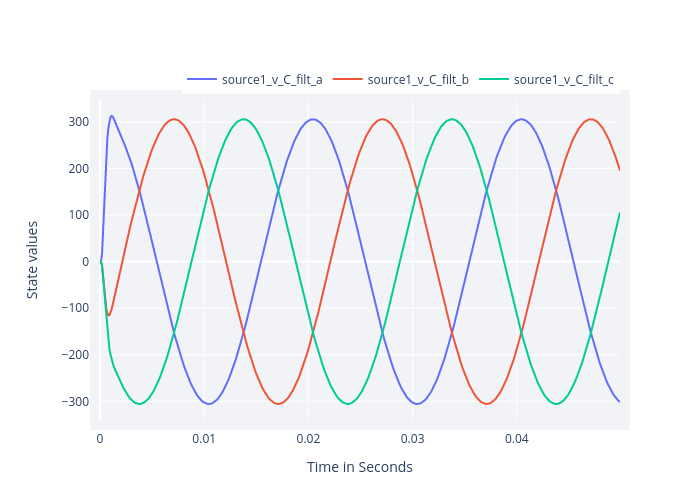

In [25]:
CM = [0. 1.
    -1. 0.]


parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                        ],
        "load"   => Any[
                        Dict{Any, Any}("impedance" => "R", "R" => R_load)
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                        ],
        "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.0)
    )

env = ElectricGridEnv(CM = CM, parameters = parameters)

states_to_plot = ["source1_v_C_filt_a", "source1_v_C_filt_b", "source1_v_C_filt_c"]
action_to_plot = ["source1_u_a"]

hook = DataHook(collect_state_ids = states_to_plot)

Controller = SetupAgents(env)
Simulate(Controller, env, hook=hook)

RenderHookResults(hook = hook,
                  states_to_plot  = states_to_plot)

Based on this introduction, more enhanced environments can be created consisting of more sources and loads connected to each other, e.g.,
- controlled by classic grid controllers to share the power based on the droop concept --> See: `Classic_Controllers_Notebooks`,
- train RL agents to fullfill current control for single sources --> See: `RL_Single_Agent.ipynb`,
- train RL agents to interact in a larger power grid with classically controlled sources --> See: `RL_Classical_Controllers_Merge.ipynb`.